# SCAN: Initial modeling (memoryless models)

In [11]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras import layers
#import tensorflow_models as tfm

import tensorflow_datasets as tfds
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import data_utils
import model_utils

import sys; sys.path.append('../')
import transformer_modules
import utils

## Date prep

In [12]:
train_ds, test_ds, command_vectorizer, action_vectorizer = data_utils.load_scan_ds('length')

tokenized_target_train tf.Tensor(
[[8 2 2 ... 0 0 0]
 [8 6 6 ... 0 0 0]
 [8 5 3 ... 0 0 0]
 ...
 [8 3 7 ... 0 0 0]
 [8 2 2 ... 0 0 0]
 [8 3 3 ... 0 0 0]], shape=(16990, 49), dtype=int64)
tokenized_target_test tf.Tensor(
[[8 2 2 ... 0 0 0]
 [8 6 6 ... 0 0 0]
 [8 5 3 ... 0 0 0]
 ...
 [8 3 7 ... 0 0 0]
 [8 2 2 ... 0 0 0]
 [8 3 3 ... 0 0 0]], shape=(16990, 49), dtype=int64)


In [13]:
print('# training samples:', len(train_ds))
print('# testing samples:', len(test_ds))
print()

print('sample of input/target/label samples...')
# print sample of dataset
for (s, t), y in train_ds.take(3):
    print(f'INPUT: {data_utils.invert_seq_vector(s.numpy(), command_vectorizer)}')
    print(f'INPUT: {s.numpy()}')
    print(f'TARGET: {data_utils.invert_seq_vector(t.numpy(), action_vectorizer)}')
    print(f'TARGET: {t.numpy()}')
    print(f'LABEL: {data_utils.invert_seq_vector(y.numpy(), action_vectorizer)}')
    print(f'LABEL: {y.numpy()}')
    print()

# training samples: 16990
# testing samples: 3920

sample of input/target/label samples...
INPUT: turn around right thrice after walk opposite right thrice
INPUT: [14  9  2  6  8 10  5  2  6]
TARGET: <START> I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <END>                          
TARGET: [8 2 2 4 2 2 4 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 9 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0]
LABEL: I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <END>                           
LABEL: [2 2 4 2 2 4 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 9 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 

In [14]:
print(train_ds.element_spec)

((TensorSpec(shape=(9,), dtype=tf.int64, name=None), TensorSpec(shape=(49,), dtype=tf.int64, name=None)), TensorSpec(shape=(49,), dtype=tf.int64, name=None))


## Transformer

In [15]:
# hyperparams
enc_dec_kwargs = dict(num_layers=2, num_heads=8, dff=128, layernorm_first=True)
embedding_dim = 64

def create_transformer_model(embedding_dim, enc_kwargs, dec_kwargs, hidden_dense_size,
    source_vocab=len(command_vectorizer.get_vocabulary()), target_vocab=len(action_vectorizer.get_vocabulary())):

    # define layers
    x_embedder = layers.Embedding(input_dim=source_vocab, output_dim=embedding_dim, name='source_embedder')
    y_embedder = layers.Embedding(input_dim=target_vocab, output_dim=embedding_dim, name='target_embedder')
    add_pos_embedding_src = transformer_modules.AddPositionalEmbedding(name='pos_embedding_src')
    add_pos_embedding_tgt = transformer_modules.AddPositionalEmbedding(name='pos_embedding_tgt')

    encoder = transformer_modules.Encoder(**enc_kwargs, name='encoder')
    decoder = transformer_modules.Decoder(**dec_kwargs, name='decoder')

    hidden_dense = layers.Dense(hidden_dense_size, activation='relu', name='hidden_dense')
    out_dense = layers.Dense(action_vectorizer.vocabulary_size(), name='output')

    # define model
    inputs = layers.Input(shape=train_ds.element_spec[0][0].shape, name='source [commands]')
    targets = layers.Input(shape=train_ds.element_spec[0][1].shape, name='target [actions]')
    x = x_embedder(inputs)
    x = add_pos_embedding_src(x)
    x = encoder(x)
    y = y_embedder(targets)
    y = add_pos_embedding_tgt(y)
    y = decoder(y, x)
    out = hidden_dense(y)
    out = out_dense(out)

    model = tf.keras.Model(inputs=[inputs, targets], outputs=out, name='transformer')
    return model

model = create_transformer_model(embedding_dim, enc_dec_kwargs, enc_dec_kwargs, 128)
model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 source [commands] (InputLa  [(None, 9)]                  0         []                            
 yer)                                                                                             
                                                                                                  
 target [actions] (InputLay  [(None, 49)]                 0         []                            
 er)                                                                                              
                                                                                                  
 source_embedder (Embedding  (None, 9, 64)                960       ['source [commands][0][0]']   
 )                                                                                      

(TensorSpec(shape=(9,), dtype=tf.int64, name=None), TensorSpec(shape=(49,), dtype=tf.int64, name=None))


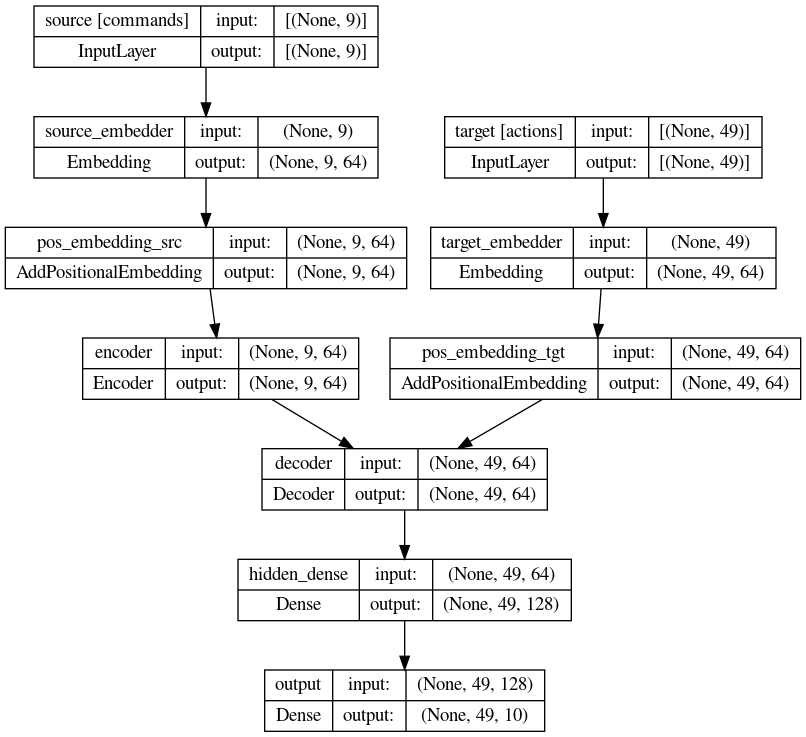

In [16]:
print(train_ds.element_spec[0])
tf.keras.utils.plot_model(model, show_shapes=True)

In [17]:
# compile model
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()
metrics = [transformer_modules.TeacherForcingAccuracy(ignore_class=action_vectorizer.get_vocabulary().index(''))]
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [18]:
# train model
epochs = 20
batch_size = 128
val_size = 1000

val_ds = train_ds.take(val_size).batch(batch_size)
train_ds_ = train_ds.skip(val_size).batch(batch_size)

history = model.fit(train_ds_, validation_data=val_ds, epochs=epochs)

Epoch 1/20
125/125 [==============================] - 29s 171ms/step - loss: 0.3555 - teacher_forcing_accuracy: 0.4991 - val_loss: 0.1833 - val_teacher_forcing_accuracy: 0.6711
Epoch 2/20
125/125 [==============================] - 20s 160ms/step - loss: 0.1736 - teacher_forcing_accuracy: 0.6789 - val_loss: 0.1299 - val_teacher_forcing_accuracy: 0.7534
Epoch 3/20
125/125 [==============================] - 20s 160ms/step - loss: 0.1232 - teacher_forcing_accuracy: 0.7682 - val_loss: 0.0779 - val_teacher_forcing_accuracy: 0.8613
Epoch 4/20
125/125 [==============================] - 20s 160ms/step - loss: 0.0891 - teacher_forcing_accuracy: 0.8393 - val_loss: 0.0453 - val_teacher_forcing_accuracy: 0.9237
Epoch 5/20
125/125 [==============================] - 20s 161ms/step - loss: 0.0531 - teacher_forcing_accuracy: 0.9096 - val_loss: 0.0191 - val_teacher_forcing_accuracy: 0.9692
Epoch 6/20
125/125 [==============================] - 20s 162ms/step - loss: 0.0342 - teacher_forcing_accuracy: 0.9

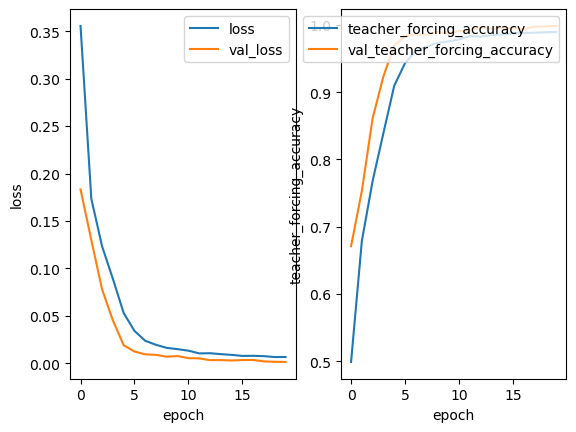

In [19]:
utils.plot_history(history, plot_attrs=('loss', 'teacher_forcing_accuracy'), val=True);

In [20]:
tokenized_source_test, tokenized_target_test, tokenized_label_test = data_utils.unravel_ds(test_ds, format='s,t,l')
target_length = np.shape(tokenized_target_test)[1]

test_pred = model_utils.autoregressive_predict_batch(model, tokenized_source_test, target_length,
    start_token=action_vectorizer.get_vocabulary().index('<START>'), batch_size=256)

full_seq_acc = np.all(test_pred == tokenized_label_test, axis=1).mean()
print(f'full seq acc: {full_seq_acc}')

per_token_acc = np.mean(test_pred == tokenized_label_test)
print(f'per-token acc: {per_token_acc}')

# teacher-forcing accuracy on test data
_, tfacc = model.evaluate(test_ds.batch(batch_size), verbose=False)
print(f'teacher-forcing accuracy: {tfacc}')

100%|██████████| 16/16 [01:54<00:00,  7.17s/it]


full seq acc: 0.0
per-token acc: 0.7891607663473552
teacher-forcing accuracy: 0.8183804750442505


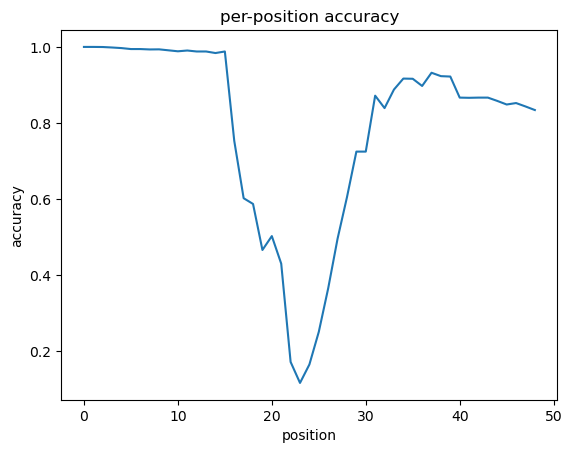

In [22]:
positional_avg_acc = np.mean(test_pred == tokenized_label_test, axis=0)
fig, ax = plt.subplots()
ax.plot(positional_avg_acc);
ax.set_title('per-position accuracy');
ax.set_xlabel('position');
ax.set_ylabel('accuracy');